In [1]:
import numpy as np
from uncertainties import ufloat
import uncertainties.unumpy as unp 

import pandas as pd
import matplotlib.pyplot as plt

import os
import copy

from scipy.optimize import curve_fit

In [2]:
# values
m = 0.324 #Kg Probengewicht
M = 0.0635 #Kg/Mol molare Masse von Cu
kappa = 137.8 * 10**9 #Pa
rho = 8960 #Kg/m**3

V0 = M/rho #Molvolumen

In [3]:
# read in data
df = pd.read_csv('data.csv')
print(df.keys())

Index(['U_p', 't', 'R_p', 'R_g', 'I_p', 'I_g'], dtype='object')


In [4]:
# uncertainties
err_R = 0.1 #Ohm
err_U = 0.01 #V
err_I = 0.1 #mA
err_t = 5 #s

In [5]:
# define measures with uncertainties

R_p = unp.uarray(df['R_p'].to_numpy(), err_R)
R_g = unp.uarray(df['R_g'].to_numpy(), err_R)

U_p = unp.uarray(df['U_p'].to_numpy(), err_U)
I_p = unp.uarray(df['I_p'].to_numpy(), err_I)

t = unp.uarray(df['t'].to_numpy(), err_t)

In [6]:
# get temperature from resistance
def T_func(R):
    return 0.00134*R**2 + 2.296*R - 243.02 + 272.15

T_p = T_func(R_p)
T_g = T_func(R_g)

In [7]:
# create delta t from t

delta_t = np.zeros_like(t)
delta_t[0] = ufloat(0,0)

for i in range(len(t)-1):
    delta_t[i+1] = t[i+1]-t[i]

In [8]:
# create delta T from T

delta_T_p = copy.deepcopy(T_p)
delta_T_p[0] = ufloat(0,0)

for i in range(len(T_p)-1):
    delta_T_p[i+1] = T_p[i+1]-T_p[i]

# Temperature course

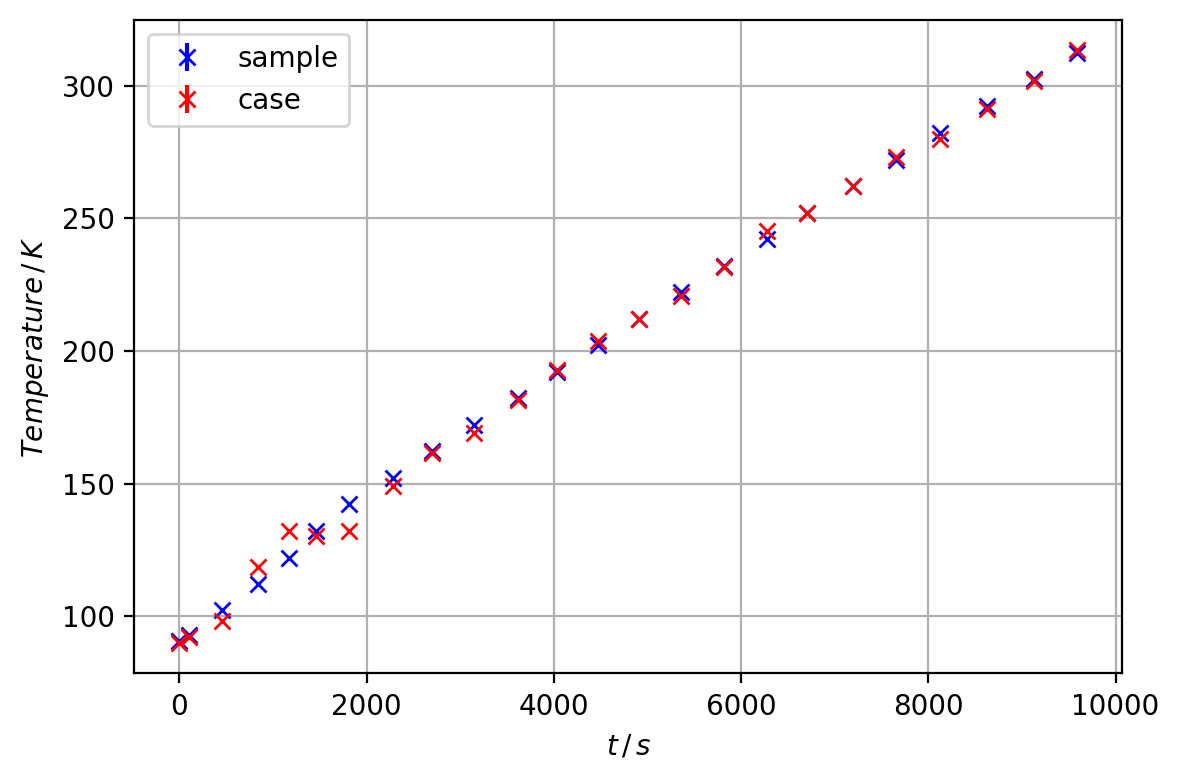

In [9]:
plt.figure(figsize=(6,4), dpi=200)
plt.errorbar(unp.nominal_values(t), unp.nominal_values(T_p), yerr=unp.std_devs(T_p),  fmt='bx', label='sample')
plt.errorbar(unp.nominal_values(t), unp.nominal_values(T_g), yerr=unp.std_devs(T_g),  fmt='rx', label='case')

plt.ylabel(r'$Temperature \,/\, K$')
plt.xlabel(r'$t \,/\, s$')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Heat capacity C_p

In [10]:
# ignore first value due no temperature difference

U_p = U_p[1:]
I_p = I_p[1:]
T_p = T_p[1:]
delta_T_p = delta_T_p[1:]
t = t[1:]
delta_t = delta_t[1:]

In [11]:
# supplied energy 
def E_func(U,I,delta_t):
    return U*I*delta_t

E = E_func(U_p, I_p/1000, delta_t)

In [12]:
# heat capacity C_p
C_p = M*E/(m*delta_T_p) #J*M

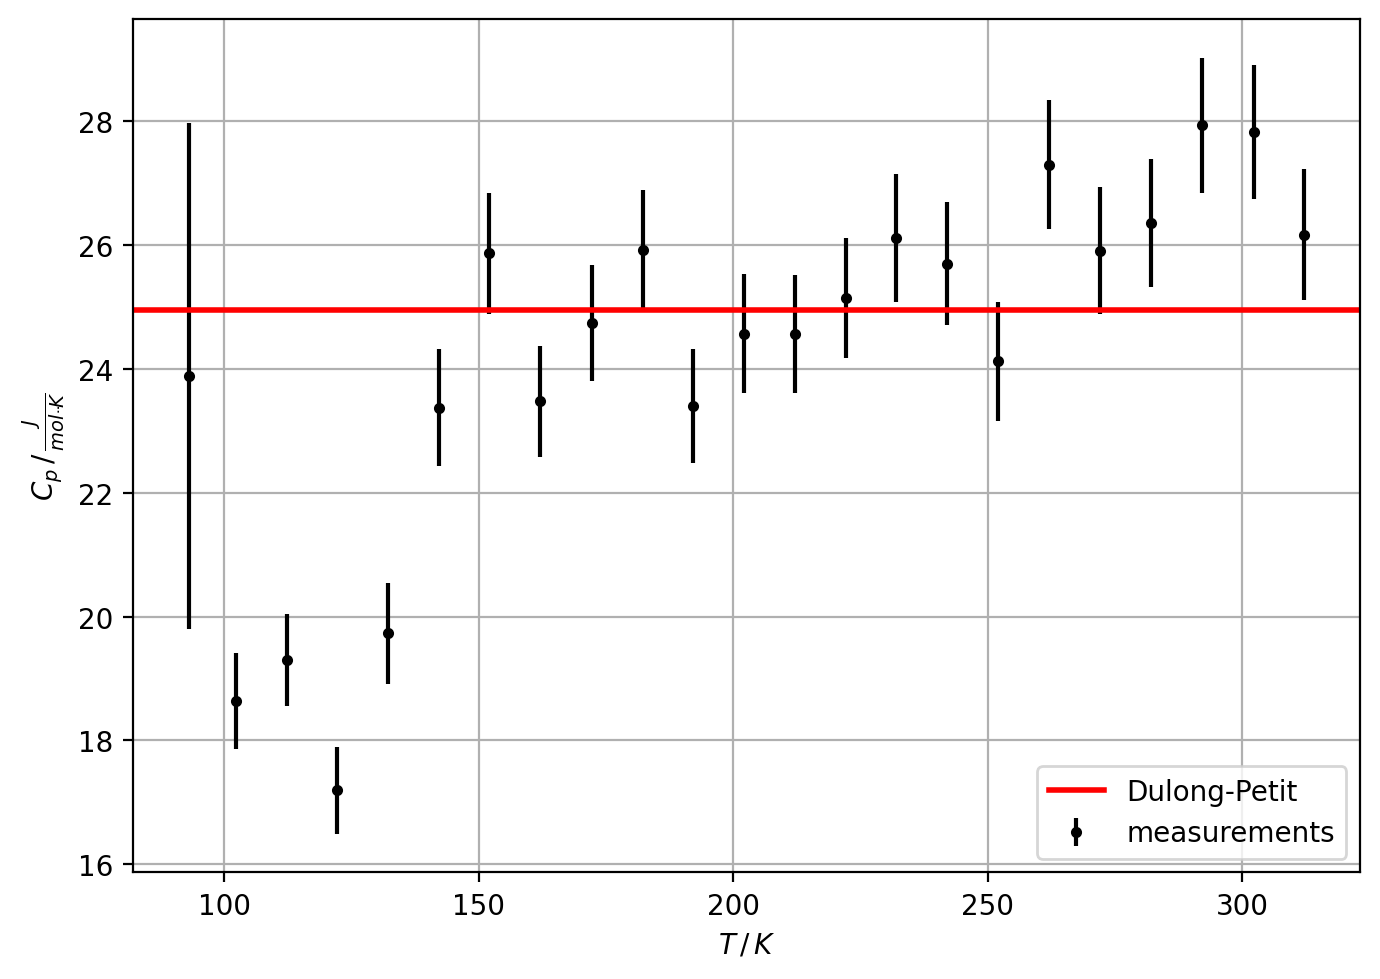

In [13]:
plt.figure(figsize=(7,5), dpi=200)
plt.errorbar(unp.nominal_values(T_p), unp.nominal_values(C_p), yerr=unp.std_devs(C_p),  fmt='k.', label='measurements')
plt.axhline(3*8.314, color='red', linewidth=2, label='Dulong-Petit')
plt.xlabel(r'$T \, / \, K$')
plt.ylabel(r'$C_p \, / \, \frac{J}{mol \ddot K}$')

plt.grid()
plt.legend(loc=4)
plt.tight_layout()
plt.savefig('build/C_p.pdf')
plt.show()

## Fitting alpha-temperature-dependency

In [14]:
df_alpha = pd.read_csv('alpha.csv')
df_alpha['alpha'] = df_alpha['alpha']*10**(-6)

In [15]:
def f_alpha(T, m ,b):
    #temperature in K
    return m*T**(-1) + b

In [16]:
params, cov = curve_fit(f_alpha, df_alpha['T'].to_numpy(), df_alpha['alpha'].to_numpy())
uncertainties = np.sqrt(np.diag(cov))

In [17]:
m = ufloat(params[0], uncertainties[0])
b = ufloat(params[1], uncertainties[1])

print(f'm = {m}')
print(f'b = {b} 1/K')

m = -0.000873+/-0.000004
b = (1.9411+/-0.0029)e-05 1/K


In [18]:
T_lin = np.linspace(df_alpha['T'].min(), df_alpha['T'].max(), 100)

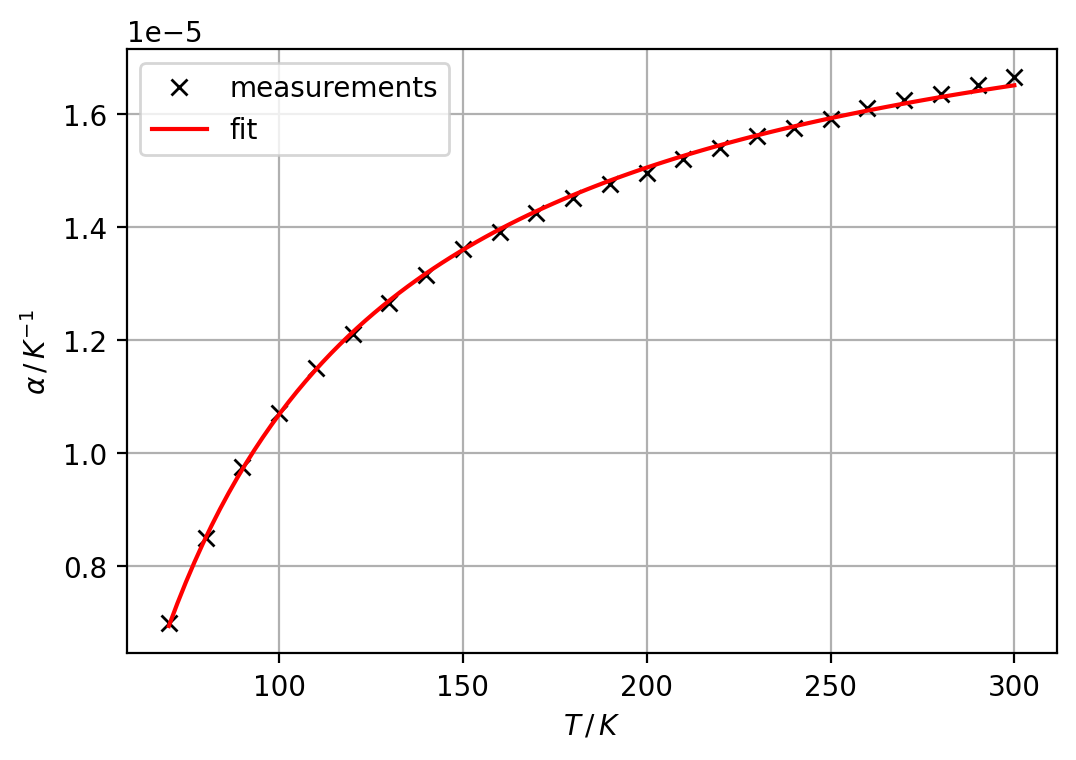

In [19]:
plt.figure(figsize=(6,4),dpi=200)
plt.plot(df_alpha['T'], df_alpha['alpha'], 'kx', label='measurements')
plt.plot(T_lin, f_alpha(T_lin, *params), 'r-', label='fit')
plt.xlabel(r'$T\,/\,K$')
plt.ylabel(r'$\alpha \,/\, K^{-1}$')
plt.grid()
plt.legend()
plt.savefig('build/temperature_progress.pdf')

In [20]:
alpha = f_alpha(T_p, m, b)

## Progress of C_V 

In [21]:
def f_C_V(C_P, alpha, T):
    return C_P - 9 * alpha**2 * kappa * V0 * T

In [22]:
C_p.shape, alpha.shape, T_p.shape

((23,), (23,), (23,))

In [23]:
C_v = f_C_V(C_p, alpha, T_p)

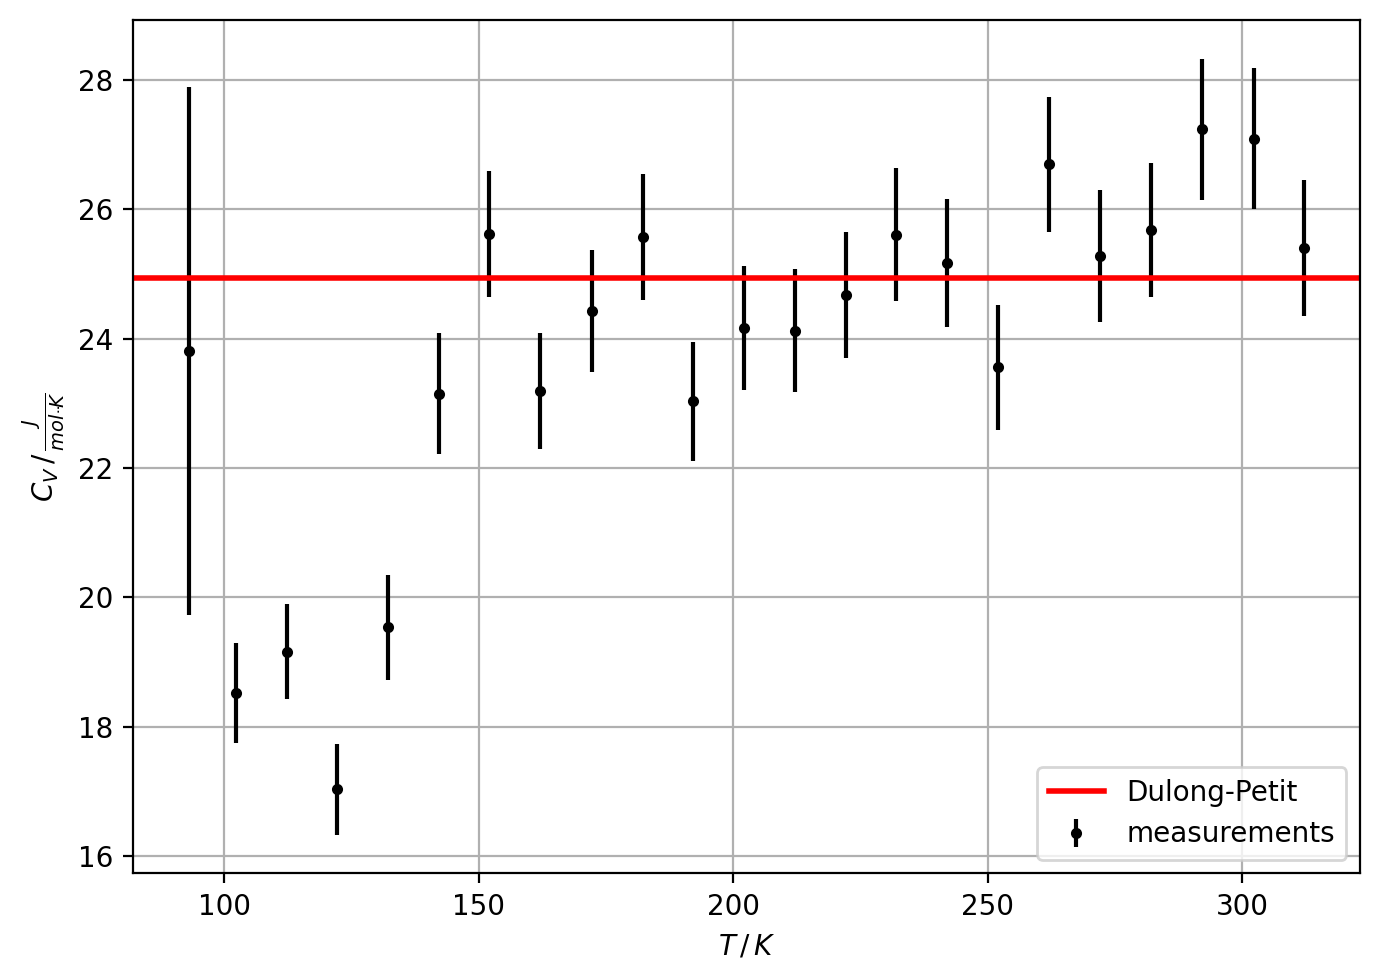

In [24]:
plt.figure(figsize=(7,5), dpi=200)
plt.errorbar(unp.nominal_values(T_p), unp.nominal_values(C_v), yerr=unp.std_devs(C_v),  fmt='k.', label='measurements')
#plt.errorbar(unp.nominal_values(T_p), unp.nominal_values(C_p), yerr=unp.std_devs(C_p),  fmt='b.', label='measurements')

plt.axhline(3*8.314, color='red', linewidth=2, label='Dulong-Petit')
plt.xlabel(r'$T \, / \, K$')
plt.ylabel(r'$C_V \, / \, \frac{J}{mol \ddot K}$')

plt.grid()
plt.legend(loc=4)
plt.tight_layout()
plt.savefig('build/C_V.pdf')
plt.show()

## Debye Temperature
> consider values with T<170K

In [25]:
ind = T_p<170
T_p_cut = T_p[ind]
T_p_cut #first 8 values

array([93.04641839999996+/-0.2369432, 102.30758459999998+/-0.2379884,
       112.32673499999996+/-0.23911400000000002,
       122.15293439999996+/-0.2402128,
       132.26550959999997+/-0.24133839999999998,
       142.18290939999997+/-0.24243720000000002,
       152.14535999999998+/-0.24353599999999997,
       162.15286139999998+/-0.2446348], dtype=object)

In [26]:
C_v_cut = C_v[ind]
C_v_cut

array([23.80594805510366+/-4.08431995151291,
       18.528724249064286+/-0.7746456297048249,
       19.164530177854477+/-0.7382164337182612,
       17.037109028943856+/-0.7031981454513797,
       19.53754869378602+/-0.815037213628939,
       23.15202820602901+/-0.9397996741003626,
       25.61053627828092+/-0.973893960360235,
       23.193426370878147+/-0.8996541690476186], dtype=object)

In [27]:
theta_T = np.array([1.0, 2.5, 2.4, 2.9, 2.3, 1.2, 0.0, 1.2])
theta_T.shape

(8,)

In [28]:
theta = theta_T*T_p_cut
theta

array([93.04641839999996+/-0.2369432, 255.76896149999996+/-0.594971,
       269.5841639999999+/-0.5738736000000001,
       354.2435097599999+/-0.69661712,
       304.21067207999994+/-0.5550783199999999,
       170.61949127999995+/-0.29092464, 0.0+/-0,
       194.58343367999996+/-0.29356176], dtype=object)

In [39]:
np.mean(theta)

205.25708133749993+/-0.1631557196145729

## Save results to csv

In [30]:
data_a = {'delta_T_p': delta_T_p, 'U_p': U_p, 'I_p': I_p, 'delta_t': delta_t, 'C_p': C_p}
df_results_a = pd.DataFrame(data = data_a)
df_results_a.to_csv('build/C_p.csv', index=False)

In [31]:
data_b = {'T_p': T_p, 'C_p': C_p, 'alpha': alpha, 'C_v': C_v}
df_results_b = pd.DataFrame(data = data_b)
df_results_b.to_csv('build/C_v.csv', index=False)

In [32]:
theta_T.shape, C_v.shape, T_p.shape, theta.shape

((8,), (23,), (23,), (8,))

In [33]:
data_c = {'C_v': C_v_cut, 'theta/T': theta_T, 'T_p': T_p_cut, 'theta': theta}
df_results_c = pd.DataFrame(data = data_c)
df_results_c.to_csv('build/debye.csv', index=False)